In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, shapiro, probplot, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [35]:
# Load the dataset
file = '../ISLR/data/Wage.csv'
data = pd.read_csv(file)
print(data.head())

   Unnamed: 0  year  age            maritl      race        education  \
0      231655  2006   18  1. Never Married  1. White     1. < HS Grad   
1       86582  2004   24  1. Never Married  1. White  4. College Grad   
2      161300  2003   45        2. Married  1. White  3. Some College   
3      155159  2003   43        2. Married  3. Asian  4. College Grad   
4       11443  2005   50       4. Divorced  1. White       2. HS Grad   

               region        jobclass          health health_ins   logwage  \
0  2. Middle Atlantic   1. Industrial       1. <=Good      2. No  4.318063   
1  2. Middle Atlantic  2. Information  2. >=Very Good      2. No  4.255273   
2  2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes  4.875061   
3  2. Middle Atlantic  2. Information  2. >=Very Good     1. Yes  5.041393   
4  2. Middle Atlantic  2. Information       1. <=Good     1. Yes  4.318063   

         wage  
0   75.043154  
1   70.476020  
2  130.982177  
3  154.685293  
4   75.04315

In [36]:
# Drop the first feature (unnamed)
data = data.iloc[:, 1:]

# Number of features
num_features = data.shape[1]
print(f'Number of features: {num_features}')

# Feature names
feature_names = data.columns.tolist()
print(f'Feature names: {feature_names}')

Number of features: 11
Feature names: ['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins', 'logwage', 'wage']


In [37]:
# Drop the feature (logwage)
drops = ['logwage']
data = data.drop(columns=drops)

# Number of features
num_features = data.shape[1]
print(f'Number of features: {num_features}')

# Feature names
feature_names = data.columns.tolist()
print(f'Feature names: {feature_names}')

Number of features: 10
Feature names: ['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins', 'wage']


In [38]:
# Number of data points
num_data_points = data.shape[0]
print(f'Number of data points: {num_data_points}')

Number of data points: 3000


In [39]:
print(data)

      year  age            maritl      race        education  \
0     2006   18  1. Never Married  1. White     1. < HS Grad   
1     2004   24  1. Never Married  1. White  4. College Grad   
2     2003   45        2. Married  1. White  3. Some College   
3     2003   43        2. Married  3. Asian  4. College Grad   
4     2005   50       4. Divorced  1. White       2. HS Grad   
...    ...  ...               ...       ...              ...   
2995  2008   44        2. Married  1. White  3. Some College   
2996  2007   30        2. Married  1. White       2. HS Grad   
2997  2005   27        2. Married  2. Black     1. < HS Grad   
2998  2005   27  1. Never Married  1. White  3. Some College   
2999  2009   55      5. Separated  1. White       2. HS Grad   

                  region        jobclass          health health_ins  \
0     2. Middle Atlantic   1. Industrial       1. <=Good      2. No   
1     2. Middle Atlantic  2. Information  2. >=Very Good      2. No   
2     2. Middle At

In [40]:
# Function to display summary of each feature in the order they appear in the CSV
def feature_summary(data):
    summary = {}
    
    for col in data.columns:
        if col in ['year']:  # Integer features
            summary[col] = data[col].describe().astype(int)
        elif col in ['age', 'wage']: # Numerical features with 2 decimals
            summary[col] = data[col].describe().round(2)
        else: # Categorical features
            summary[col] = data[col].value_counts().sort_index()
    
    return summary

# Call the function to get feature summaries
feature_summaries = feature_summary(data)

# Print summaries
for col, summary in feature_summaries.items():
    print(f'Summary for {col}:\n', summary, '\n')

Summary for year:
 count    3000
mean     2005
std         2
min      2003
25%      2004
50%      2006
75%      2008
max      2009
Name: year, dtype: int32 

Summary for age:
 count    3000.00
mean       42.41
std        11.54
min        18.00
25%        33.75
50%        42.00
75%        51.00
max        80.00
Name: age, dtype: float64 

Summary for maritl:
 maritl
1. Never Married     648
2. Married          2074
3. Widowed            19
4. Divorced          204
5. Separated          55
Name: count, dtype: int64 

Summary for race:
 race
1. White    2480
2. Black     293
3. Asian     190
4. Other      37
Name: count, dtype: int64 

Summary for education:
 education
1. < HS Grad          268
2. HS Grad            971
3. Some College       650
4. College Grad       685
5. Advanced Degree    426
Name: count, dtype: int64 

Summary for region:
 region
2. Middle Atlantic    3000
Name: count, dtype: int64 

Summary for jobclass:
 jobclass
1. Industrial     1544
2. Information    1456
Name: 


 Analyzing Feature: year vs. wage 



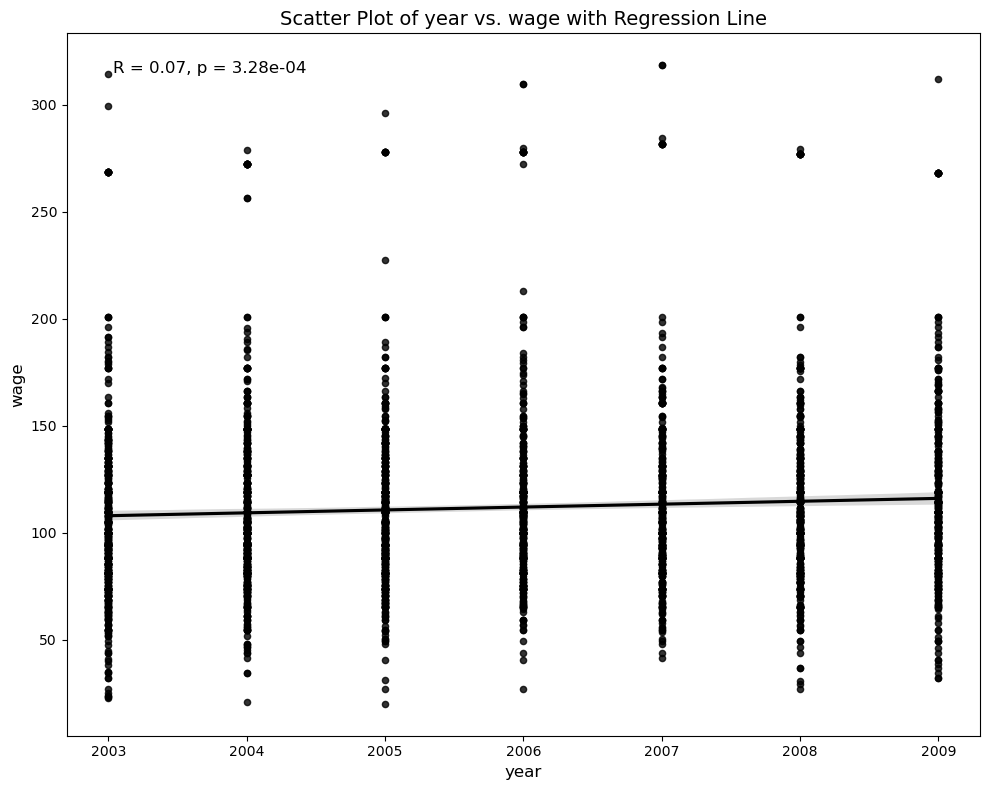

Shapiro-Wilk Test for year: W = 0.91113, p-value = 9.25e-39


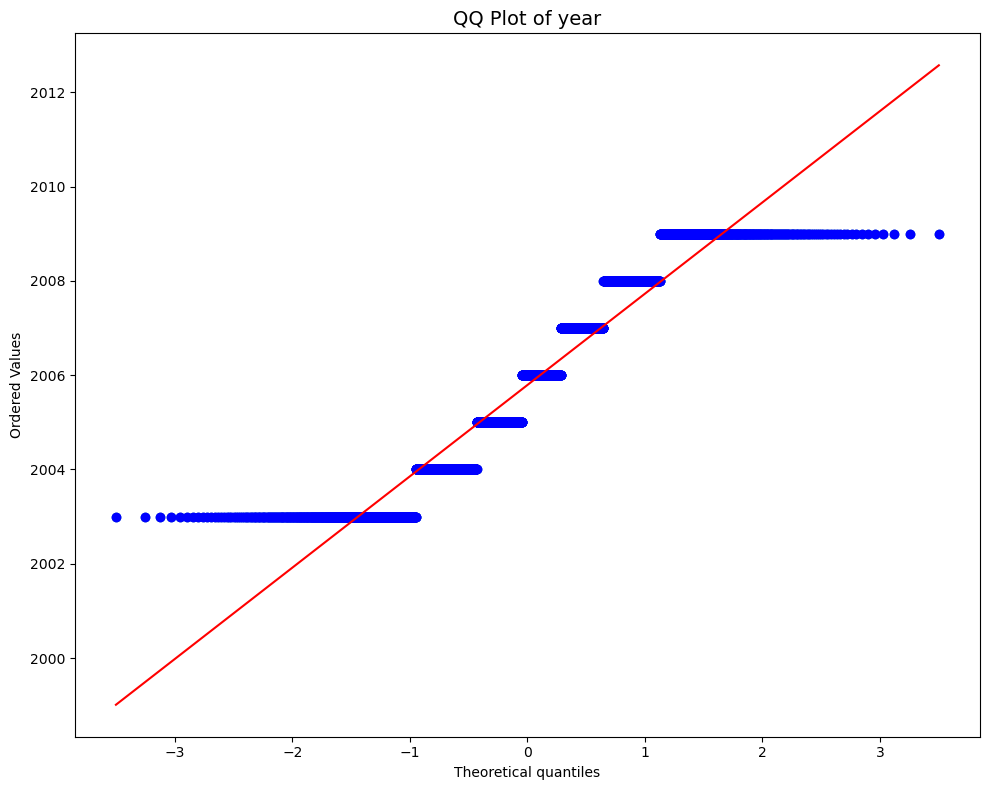

Pearson Correlation Test for year and wage:
R = 0.06554, p-value = 9.25e-39


 Analyzing Feature: age vs. wage 



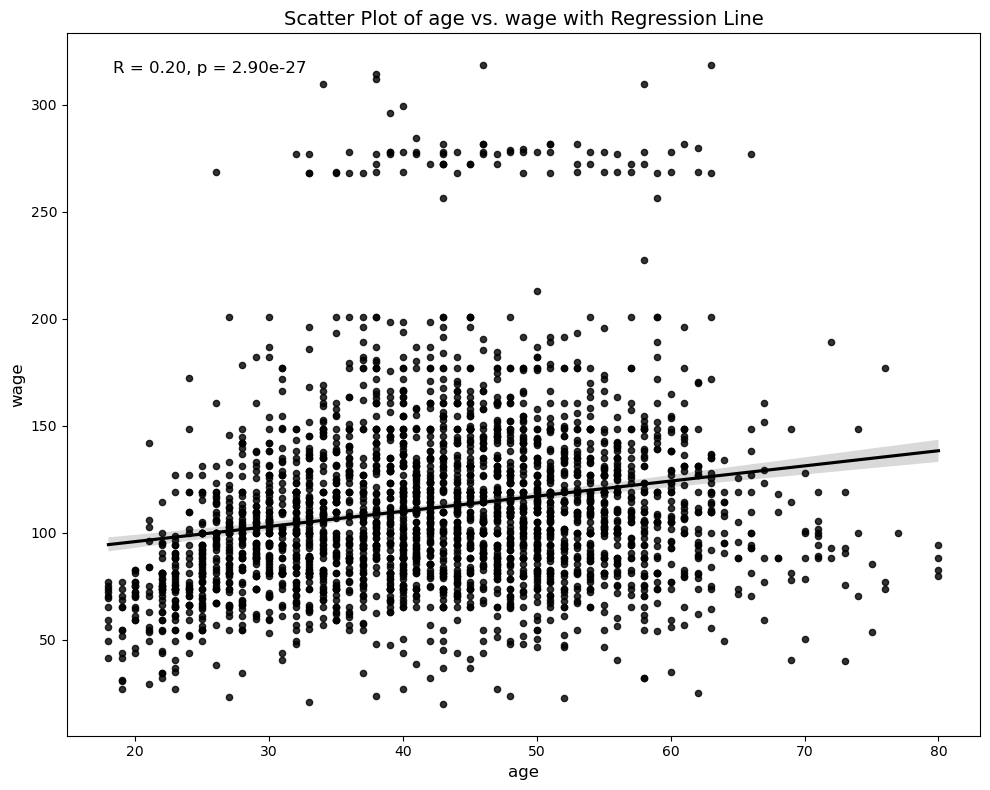

Shapiro-Wilk Test for age: W = 0.99106, p-value = 9.42e-13


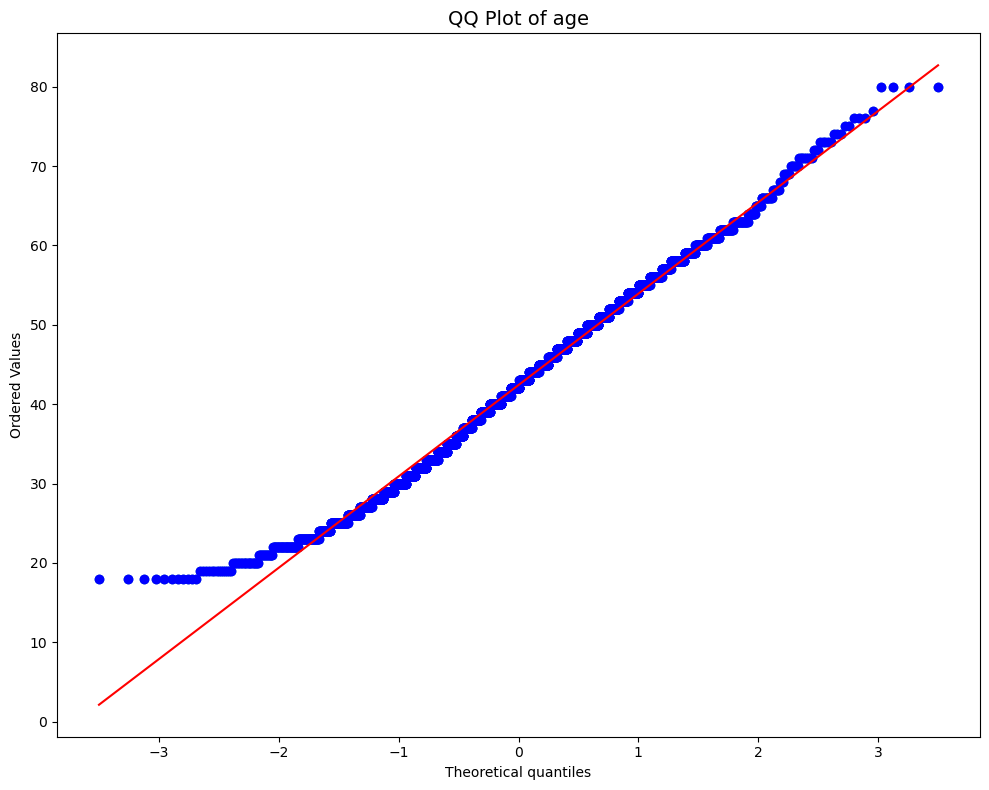

Pearson Correlation Test for age and wage:
R = 0.19564, p-value = 9.42e-13


 Analyzing Feature: wage vs. wage 



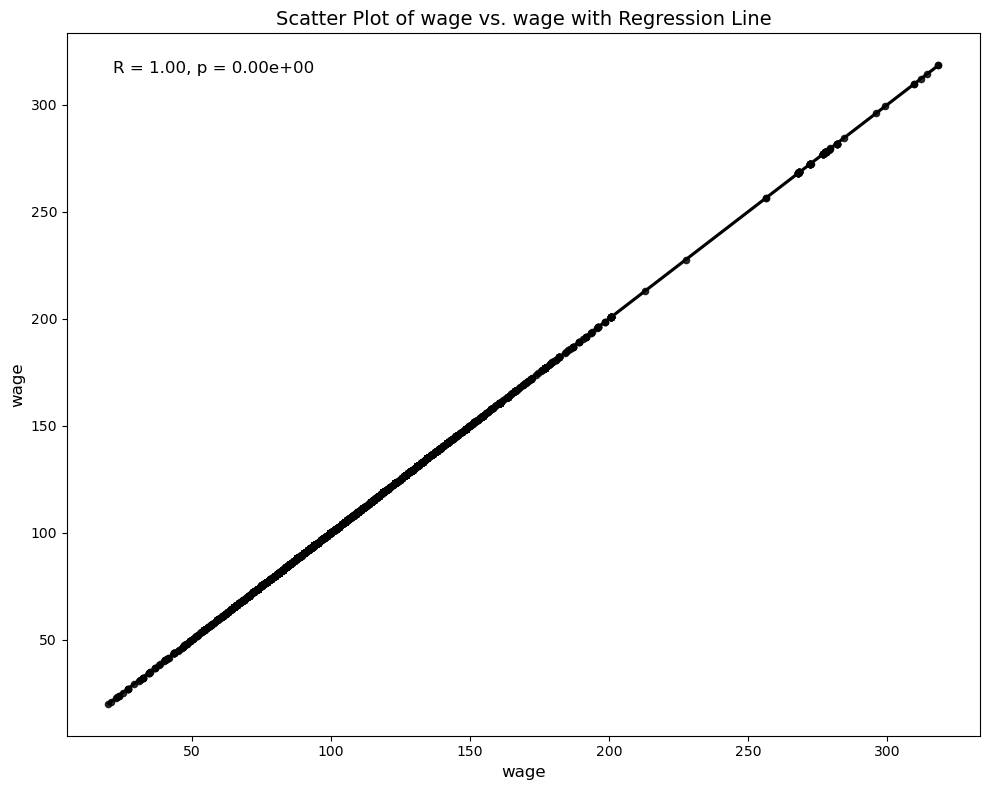

Shapiro-Wilk Test for wage: W = 0.87957, p-value = 2.46e-43


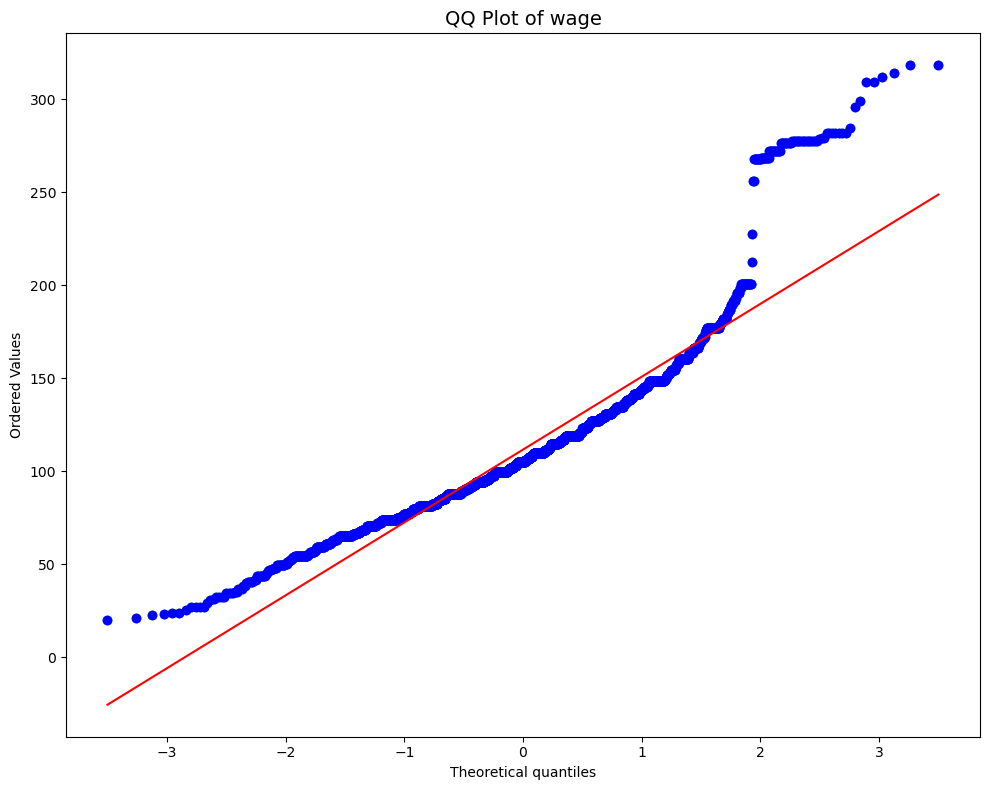

Pearson Correlation Test for wage and wage:
R = 1.00000, p-value = 2.46e-43



In [41]:
# Function to analyze each numerical feature
def analyze_correlation(data, label):
    numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
    # numerical_features = [col for col in numerical_features if col != label]

    for feature in numerical_features:
        print(f'\n Analyzing Feature: {feature} vs. {label} \n')

        # 1. Plot the feature against the label values with a regression line
        correlation, p_value = pearsonr(data[feature], data[label])
        plt.figure(figsize=(10, 8))
        sns.regplot(x=data[feature], y=data[label], ci=95, scatter_kws={'color': 'black', 's': 20}, line_kws={'color': 'black'})
        plt.text(x=0.05, y=0.95, s=f'R = {correlation:.2f}, p = {p_value:.2e}', fontsize=12, ha='left', va='center', transform=plt.gca().transAxes)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel(label, fontsize=12)
        plt.title(f'Scatter Plot of {feature} vs. {label} with Regression Line', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 2. Test the normality of the feature and label values
        stat, p_value = shapiro(data[feature])
        print(f'Shapiro-Wilk Test for {feature}: W = {stat:.5f}, p-value = {p_value:.2e}')
        plt.figure(figsize=(10, 8))
        probplot(data[feature], dist='norm', plot=plt)
        plt.scatter(plt.gca().lines[0].get_xdata(), plt.gca().lines[0].get_ydata())
        plt.title(f'QQ Plot of {feature}', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 3. Perform the Pearson correlation test
        print(f'Pearson Correlation Test for {feature} and {label}:\nR = {correlation:.5f}, p-value = {p_value:.2e}\n')

analyze_correlation(data, label='wage')

4. Interpretation of Results

Year vs. Wage:
The Pearson correlation coefficient is very low, indicating a very week linear relationship between year and wage. 
The p_value is very small, indicating that the year feature is not normally distributed. Also, it is statistical significant, the correlation is minimal, so year has little impact on predicting wage.

Age vs. Wage:
The Pearson correlation coefficient is low, indicating a week positive linear relationship between age and wage.
The p-value is small, the W statistic is close to 1, indicating that age is approximately normally distributed, but with a slight departure from normality.Also, it is statistically significant, the correlations is not strong, so age might have a small impact on wage.

Wage vs. Wage:
As expected, wage is perfectly correlated with itself.
The p_value is extremely small, indicating that wage itself is not normally distributed.


 Analyzing Feature: maritl vs. wage 

Possible values for maritl: ['1. Never Married', '2. Married', '3. Widowed', '4. Divorced', '5. Separated']


C:\Users\ronaz\AppData\Local\Temp\ipykernel_22704\3302255144.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y=label, data=data, palette='Set3')


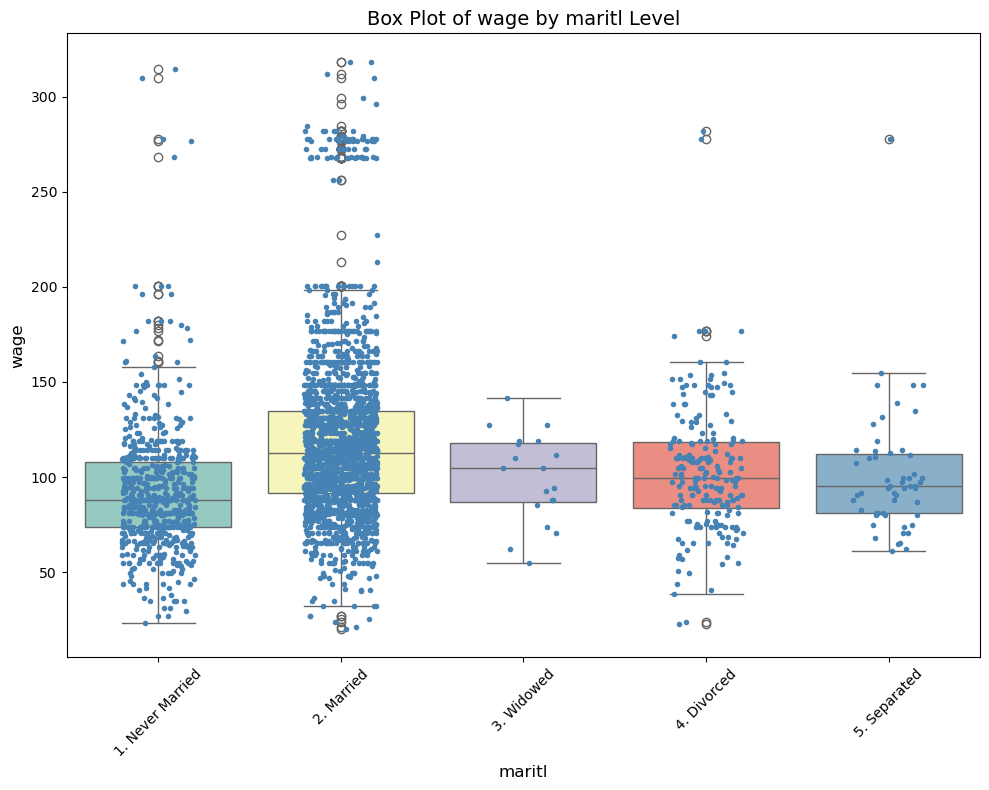

One-Way ANOVA Test
                sum_sq      df          F        PR(>F)
maritl    3.631444e+05     4.0  55.959585  1.401201e-45
Residual  4.858941e+06  2995.0        NaN           NaN

 Analyzing Feature: race vs. wage 

Possible values for race: ['1. White', '2. Black', '3. Asian', '4. Other']


C:\Users\ronaz\AppData\Local\Temp\ipykernel_22704\3302255144.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y=label, data=data, palette='Set3')


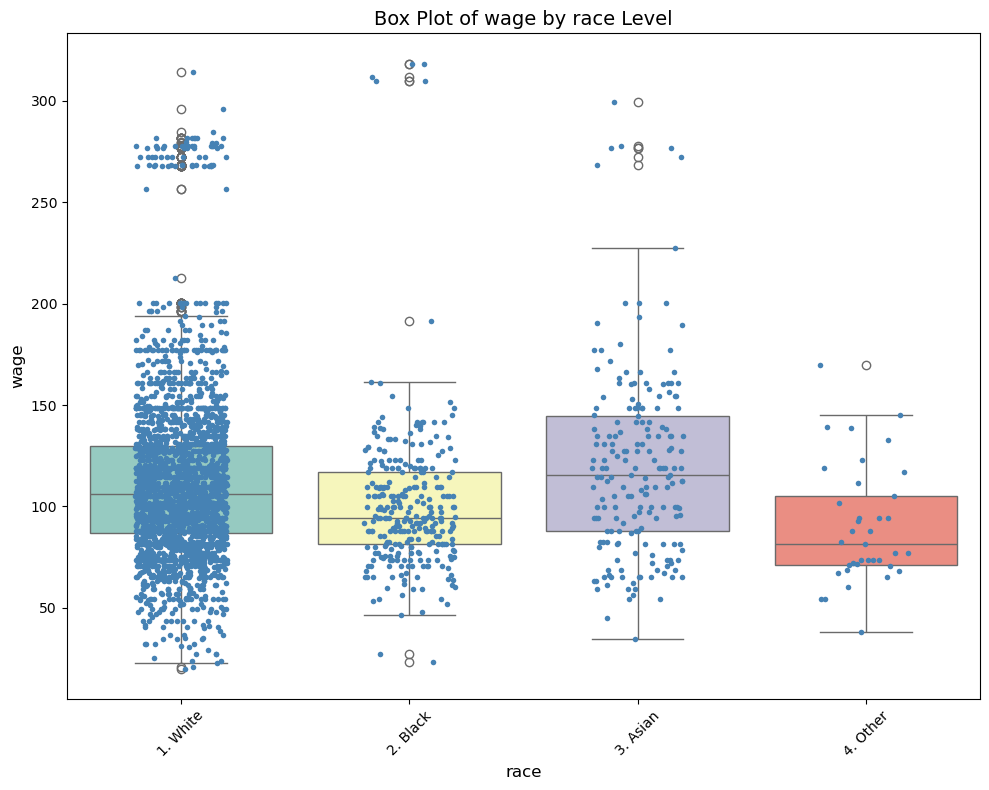

One-Way ANOVA Test
                sum_sq      df          F        PR(>F)
race      6.321174e+04     3.0  12.236674  5.890230e-08
Residual  5.158874e+06  2996.0        NaN           NaN

 Analyzing Feature: education vs. wage 

Possible values for education: ['1. < HS Grad', '2. HS Grad', '3. Some College', '4. College Grad', '5. Advanced Degree']


C:\Users\ronaz\AppData\Local\Temp\ipykernel_22704\3302255144.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y=label, data=data, palette='Set3')


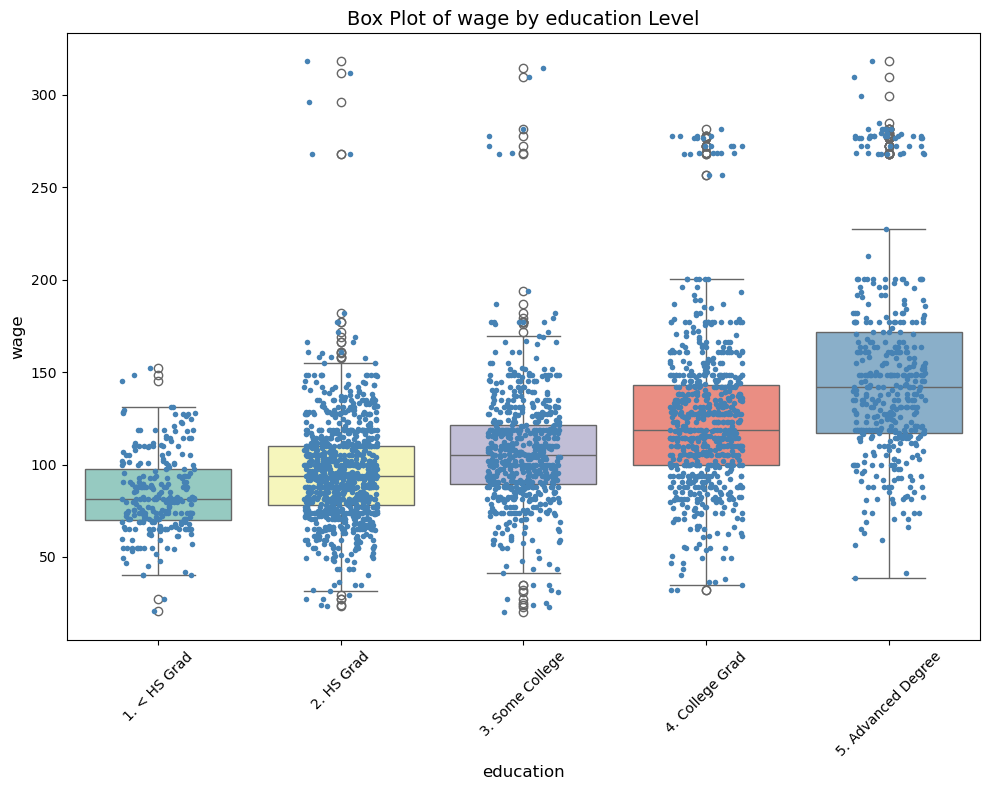

One-Way ANOVA Test
                 sum_sq      df           F         PR(>F)
education  1.226364e+06     4.0  229.805921  2.915932e-172
Residual   3.995721e+06  2995.0         NaN            NaN

 Analyzing Feature: region vs. wage 

Possible values for region: ['2. Middle Atlantic']


C:\Users\ronaz\AppData\Local\Temp\ipykernel_22704\3302255144.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y=label, data=data, palette='Set3')


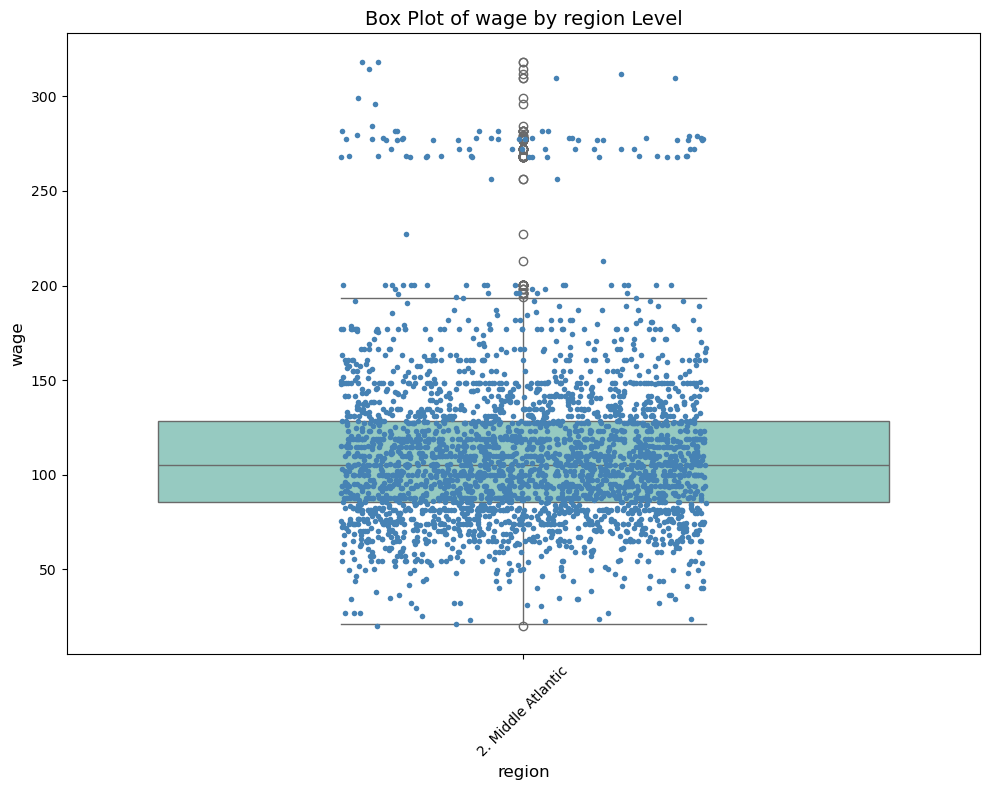

Feature region has only one unique value: 2. Middle Atlantic. ANOVA is not applicable.


 Analyzing Feature: jobclass vs. wage 

Possible values for jobclass: ['1. Industrial', '2. Information']


C:\Users\ronaz\AppData\Local\Temp\ipykernel_22704\3302255144.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y=label, data=data, palette='Set3')


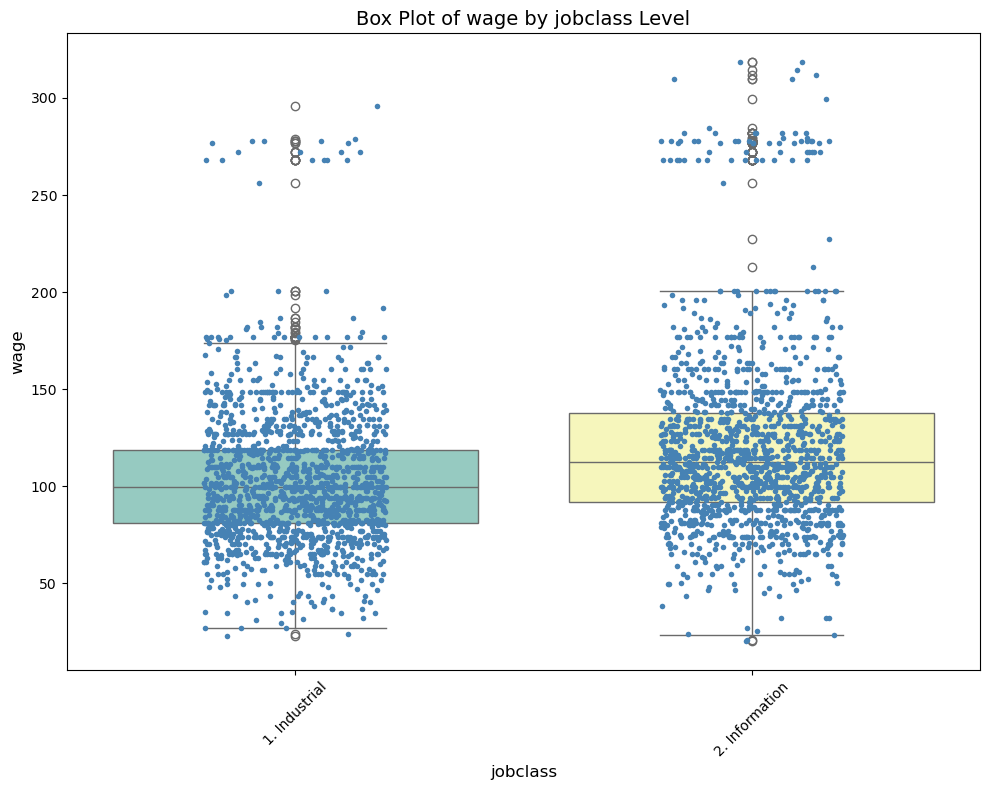

One-Way ANOVA Test
                sum_sq      df           F        PR(>F)
jobclass  2.235384e+05     1.0  134.072585  2.308186e-30
Residual  4.998547e+06  2998.0         NaN           NaN

 Analyzing Feature: health vs. wage 

Possible values for health: ['1. <=Good', '2. >=Very Good']


C:\Users\ronaz\AppData\Local\Temp\ipykernel_22704\3302255144.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y=label, data=data, palette='Set3')


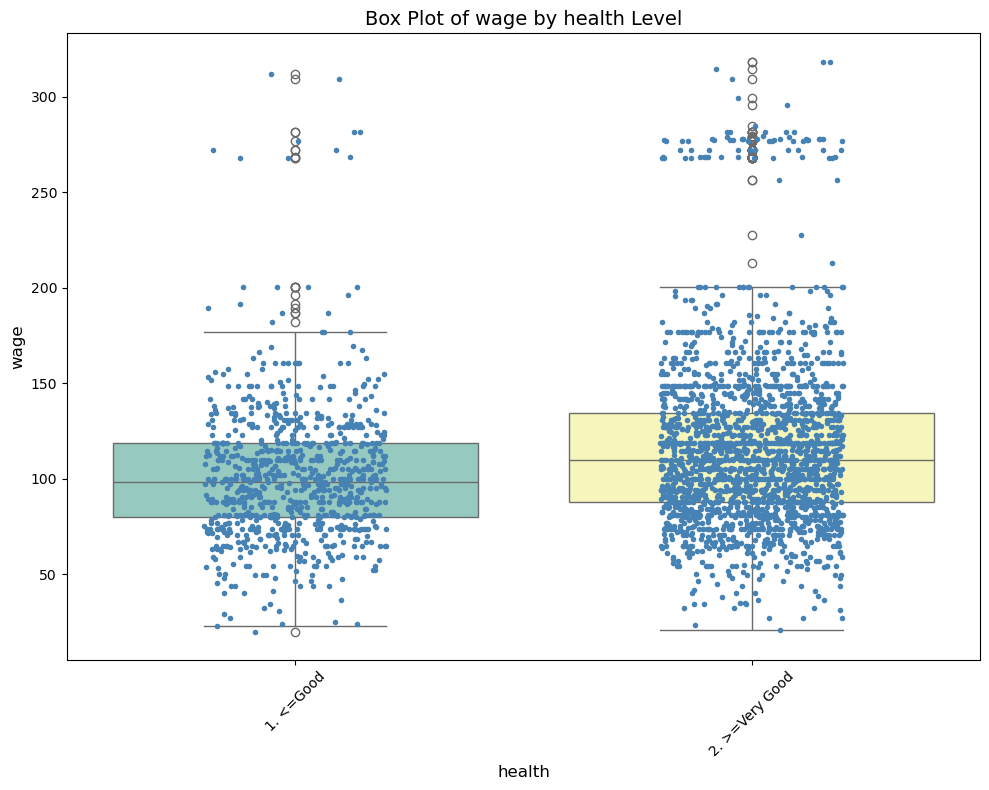

One-Way ANOVA Test
                sum_sq      df          F        PR(>F)
health    1.211874e+05     1.0  71.226641  4.886404e-17
Residual  5.100898e+06  2998.0        NaN           NaN

 Analyzing Feature: health_ins vs. wage 

Possible values for health_ins: ['1. Yes', '2. No']


C:\Users\ronaz\AppData\Local\Temp\ipykernel_22704\3302255144.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y=label, data=data, palette='Set3')


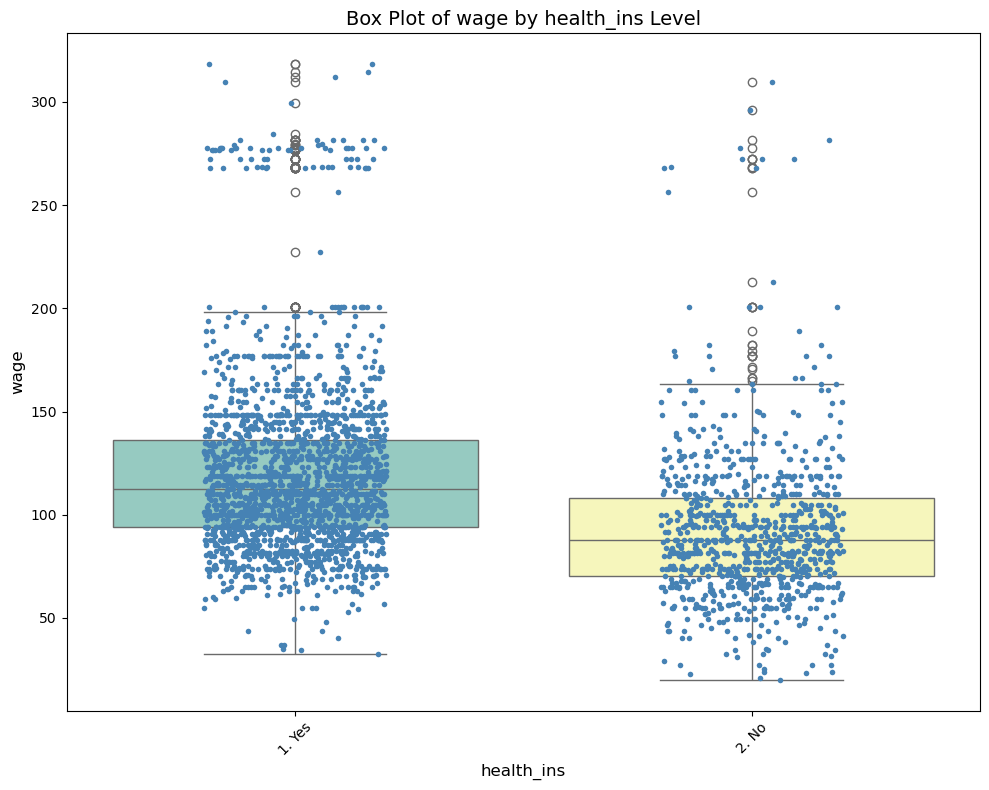

One-Way ANOVA Test
                  sum_sq      df           F        PR(>F)
health_ins  4.963846e+05     1.0  314.907964  4.465783e-67
Residual    4.725701e+06  2998.0         NaN           NaN


In [42]:
def analyze_variance(data, label):
    non_numerical_features = data.select_dtypes(exclude=['int64', 'float64']).columns

    for feature in non_numerical_features:
        print(f'\n Analyzing Feature: {feature} vs. {label} \n')

        # 1. List the possible feature values
        unique_values = data[feature].unique()

        # Sort the feature values for the x-axis
        sorted_values = sorted(unique_values)
        data[feature] = pd.Categorical(data[feature], categories=sorted_values, ordered=True)
        print(f'Possible values for {feature}: {sorted_values}')


        # 2. Plot (box plot) the label values for each group of data points with the same feature value
        plt.figure(figsize=(10, 8))
        sns.boxplot(x=feature, y=label, data=data, palette='Set3')
        sns.stripplot(x=feature, y=label, data=data, color='steelblue', jitter=0.2, size=4)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel(label, fontsize=12)
        plt.title(f'Box Plot of {label} by {feature} Level', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Check if there is only one unique value
        if len(unique_values) == 1:
            print(f'Feature {feature} has only one unique value: {unique_values[0]}. ANOVA is not applicable.\n')
            continue
        
        # 3. Perform the one-way ANOVA test
        # groups = [data[label][data[feature] == value] for value in unique_values]
        # f_stat, p_value = f_oneway(*groups)
        # print(f'One-Way ANOVA Test\nF-statistic = {f_stat:.5f}, p_value = {p_value:.2e}')
        model = ols(f'{label} ~ {feature}', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f'One-Way ANOVA Test\n{anova_table}')

analyze_variance(data, label='wage')

4. Interpretation of Results

Maritl vs. Wage:
The p_value is very low, indicating that maritl has a statistically significant impact on wage.
The F-statistic is quite high, indicating large differences in mean wages across marital status categories. So maritl is a preditor of wage differences.
This suggests that marital status has a statistically significant effect on wage, some groups (e.g., married vs. divorced) showing distinct wage distributions.

Race vs. Wage:
The p_value is low, indicating that race has a meaningful impact on wage.
The F_statistic is not that low, indicating notable differences in mean wages across racial groups.

Education vs. Wage:
The p_value is extremely low, indicating that education has a very strong and significant impact on wage.
The F_statistic is very high, indicating substantial differences in mean wages across education levels. So education is a strong preditor of wage differences.
This suggests that individuals with higher education levels likely have higher wages.

Region vs. Wage:
Since there is only one unique value for the region, ANOVA is not applicable. There is no comparison to be made.

Jobclass vs. Wage
The p_value is very low, indicating that jobclass has a statistically significant impact on wage.
The F_statistic is very high, indicating substantial differences in mean wages across job classes. So jobclass is a trong preditor of wage differences.
This suggests that individuals have information as job class potentially have higher wages.

Health vs. Wage
The p_value is low, indicating that health has a meaningful impact on wage.
The F_statistic is quite high, indicating large differences in mean wages across health status. So health is a preditor of wage differences.
This suggests that individuals in better health potentially have higher wages.

Health_ins vs. Wage
The p_value is very low, indicating that health_ins has a significant impact on wage.
The F_statistic is extremely high, indicating substantial differences in mean wages across health insurances status. So health_ins is a strong preditor of wage differences.
This suggests that individuals with health insurance likely have higher wages compared to those without it.